In [2]:
%pip install requests

  Using cached requests-2.32.3-py3-none-any.whl.metadata (4.6 kB)
Using cached requests-2.32.3-py3-none-any.whl (64 kB)
Note: you may need to restart the kernel to use updated packages.


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [1]:
%pip install bs4


Note: you may need to restart the kernel to use updated packages.


In [2]:
import requests
from bs4 import BeautifulSoup
import json
import os
from concurrent.futures import ThreadPoolExecutor, as_completed

# AllRecipes Cuisine A-Z Page
base_url = "https://www.allrecipes.com/cuisine-a-z-6740455"

# Headers to mimic a real browser request
headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36"
}

# Create the recipes directory
os.makedirs("recipes", exist_ok=True)

# Fetch the Cuisine A-Z Page
response = requests.get(base_url, headers=headers)

if response.status_code == 200:
    print("✅ Successfully fetched the Cuisine A-Z page!")
    soup = BeautifulSoup(response.text, "html.parser")

    # Find all cuisine links
    cuisine_links = {
        cuisine.text.strip(): cuisine.get("href")
        for cuisine in soup.find_all("a", class_="mntl-link-list__link")
    }

    print(f"✅ Found {len(cuisine_links)} cuisines!")

    def scrape_recipe(recipe_url, cuisine_name):
        """Fetch and parse individual recipe pages"""
        try:
            recipe_response = requests.get(recipe_url, headers=headers, timeout=10)
            if recipe_response.status_code != 200:
                print(f"❌ Failed to fetch {recipe_url} (Status: {recipe_response.status_code})")
                return None

            recipe_soup = BeautifulSoup(recipe_response.text, "html.parser")

            # Extract title
            title_element = recipe_soup.find("h1", class_="article-heading")
            title = title_element.text.strip() if title_element else "Unknown Title"

            # Extract ingredients
            ingredients = []
            for ingredient in recipe_soup.find_all("li", class_="mm-recipes-structured-ingredients__list-item"):
                quantity = ingredient.find("span", attrs={"data-ingredient-quantity": True})
                unit = ingredient.find("span", attrs={"data-ingredient-unit": True})
                name = ingredient.find("span", attrs={"data-ingredient-name": True})

                quantity_text = quantity.text.strip() if quantity else ""
                unit_text = unit.text.strip() if unit else ""
                name_text = name.text.strip() if name else ""

                full_ingredient = f"{quantity_text} {unit_text} {name_text}".strip()
                ingredients.append(full_ingredient)

            # Extract category

            return {
                "title": title,
                "ingredients": ingredients,
                "cuisine": cuisine_name,
            }

        except Exception as e:
            print(f"⚠️ Error scraping {recipe_url}: {e}")
            return None

    def scrape_cuisine(cuisine_name, cuisine_url):
        """Fetch all recipes for a given cuisine"""
        print(f"\n🍽️ Scraping cuisine: {cuisine_name}")

        try:
            cuisine_response = requests.get(cuisine_url, headers=headers, timeout=10)
            if cuisine_response.status_code != 200:
                print(f"❌ Failed to fetch {cuisine_url} (Status: {cuisine_response.status_code})")
                return

            cuisine_soup = BeautifulSoup(cuisine_response.text, "html.parser")
            recipe_links = [
                recipe.get("href")
                for recipe in cuisine_soup.find_all("a", class_="mntl-card-list-items")
            ]

            print(f"📌 Found {len(recipe_links)} recipes for {cuisine_name}")

            # Use threading to fetch multiple recipes in parallel
            recipes = []
            with ThreadPoolExecutor(max_workers=50) as executor:
                future_to_recipe = {executor.submit(scrape_recipe, url, cuisine_name): url for url in recipe_links}

                for future in as_completed(future_to_recipe):
                    recipe = future.result()
                    if recipe:
                        recipes.append(recipe)

            # Save to JSON
            file_path = f"recipes/{cuisine_name}.json"
            with open(file_path, "w") as f:
                json.dump(recipes, f, indent=4)

            print(f"✅ Successfully saved {len(recipes)} recipes for {cuisine_name} cuisine!")

        except Exception as e:
            print(f"⚠️ Error scraping cuisine {cuisine_name}: {e}")

    # Use threading to scrape multiple cuisines at the same time
    with ThreadPoolExecutor(max_workers=10) as executor:
        future_to_cuisine = {executor.submit(scrape_cuisine, name, url): name for name, url in cuisine_links.items()}

        for future in as_completed(future_to_cuisine):
            future.result()  # Ensure any exceptions are raised

    print("🎉 All cuisines scraped successfully!")

else:
    print(f"❌ Failed to fetch the Cuisine A-Z page. Status Code: {response.status_code}")


✅ Successfully fetched the Cuisine A-Z page!
✅ Found 49 cuisines!

🍽️ Scraping cuisine: Amish and Mennonite

🍽️ Scraping cuisine: Argentinian

🍽️ Scraping cuisine: Australian and New Zealander

🍽️ Scraping cuisine: Austrian

🍽️ Scraping cuisine: Bangladeshi

🍽️ Scraping cuisine: Belgian

🍽️ Scraping cuisine: Brazilian

🍽️ Scraping cuisine: Cajun and Creole

🍽️ Scraping cuisine: Canadian

🍽️ Scraping cuisine: Chilean
📌 Found 22 recipes for Austrian
📌 Found 22 recipes for Chilean
📌 Found 12 recipes for Bangladeshi
📌 Found 6 recipes for Belgian
📌 Found 32 recipes for Argentinian
📌 Found 67 recipes for Brazilian
📌 Found 67 recipes for Cajun and Creole
📌 Found 65 recipes for Australian and New Zealander
📌 Found 67 recipes for Canadian
📌 Found 63 recipes for Amish and Mennonite
✅ Successfully saved 12 recipes for Bangladeshi cuisine!

🍽️ Scraping cuisine: Chinese
✅ Successfully saved 6 recipes for Belgian cuisine!

🍽️ Scraping cuisine: Colombian
✅ Successfully saved 32 recipes for Argentinia

In [100]:
import os
import json
import pandas as pd

# Folder containing JSON files
recipe_folder = "recipes"

# Load all cuisines into a DataFrame
all_recipes = []

for file in os.listdir(recipe_folder):
    file_path = os.path.join(recipe_folder, file)
    with open(file_path, "r") as f:
        data = json.load(f)
        all_recipes.extend(data)

# Convert to DataFrame
df = pd.DataFrame(all_recipes)

# Show basic info
print(df.info())
print(df.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2457 entries, 0 to 2456
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   title        2457 non-null   object
 1   ingredients  2457 non-null   object
 2   cuisine      2457 non-null   object
dtypes: object(3)
memory usage: 57.7+ KB
None
                                              title  \
0                        Amish Buttered Egg Noodles   
1                          Herman Sourdough Starter   
2                   Kimberly's Curried Deviled Eggs   
3                    Amish Friendship Bread Starter   
4  Our Most Traditional Amish and Mennonite Recipes   

                                                                                                                                                                                                                     ingredients  \
0                                                                                   

In [101]:
# Drop duplicates based on title & cuisine
df = df.drop_duplicates(subset=["title", "cuisine"])

# Fill missing values
df["ingredients"] = df["ingredients"].apply(lambda x: x if isinstance(x, list) else [])

print(f"✅ Data cleaned! {len(df)} unique recipes remain.")


✅ Data cleaned! 2456 unique recipes remain.


In [102]:
import re

# Expanded list of words to remove
words_to_remove = [
    "baked", "grilled", "boiled", "roasted", "fried", "sauteed", "steamed", "chopped", "diced", "minced", "shredded",
    "unsalted", "salted", "fresh", "organic", "large", "small", "medium", "crushed", "ground", "whole", "peeled", "packed",
    "sliced", "cooked", "drained", "softened", "melted", "lightly", "beaten", "frozen", "skinless", "boneless",
    "halved", "quartered", "thawed", "extra", "virgin", "rinsed", "patted", "dry","dried", "finely", "coarsely", "cubed",
    "seeded", "cored", "zested", "deseeded", "trimmed", "lean", "fat", "pitted", "at", "room", "temperature", "cut", "into", "pieces",
    "left", "on", "and", "deveined", "divided", "prepared", "purpose","uncooked", "for", "frying","or","to taste", "plus", "more" ,"as", "needed", "to degrees f", "a", "ab", "about"
]

measurements = [
    "can", "cans", "package","pinch","pinches", "inch", "inches", "--","packages", "jar", "jars", "cup", "cups", "tablespoon", "tablespoons", "teaspoon", "teaspoons", "pound", "pounds", "quart", "quarts", "ounce", "ounces"
]

words_to_remove.extend(measurements)

def clean_ingredient(ingredient):
    if not ingredient or not isinstance(ingredient, str):
        return ""  # Ignore empty values
    
    # Remove everything indide () brackets
    iteration = 1
    while "(" in ingredient:
        print(f"Iteration {iteration}: {ingredient}")
        ingredient = re.sub(r"\(.*?\)", "", ingredient)  # Remove innermost brackets
        ingredient = re.sub(r"\(.*", "", ingredient)
        # # Remove any remaining unmatched brackets
        # ingredient = re.sub(r"\[|\]", "", ingredient)
        iteration += 1

    # Remove punctuation
    ingredient = re.sub(r"[.,\"\/]", "", ingredient)

    # Remove fractions and numbers
    ingredient = re.sub(r"[¼½¾⅓⅔⅕⅖⅗⅘⅙⅚⅛⅜⅝⅞]|\b\d+\b", "", ingredient)

    # Remove full phrases like 'to taste' or 'as needed'
    for phrase in words_to_remove:
        ingredient = re.sub(fr"\b(?:[\w-]+-)?{re.escape(phrase)}\b", "", ingredient, flags=re.IGNORECASE)

    # Remove single words from the list
    ingredient_words = ingredient.split()
    cleaned_words = [word for word in ingredient_words if word.lower() not in words_to_remove]

    # Join back into a cleaned ingredient name
    return " ".join(cleaned_words).strip().lower()


# Apply cleaning function
df["ingredients"] = df["ingredients"].apply(lambda x: [clean_ingredient(i) for i in x if i])  # Ignore empty values


Iteration 1: 2 (14 ounce) cans chicken broth
Iteration 1: 1 (12 ounce) package egg noodles
Iteration 1: 2 cups warm water (110 degrees F/45 degrees C)
Iteration 1: 1 (.25 ounce) package active dry yeast
Iteration 1: ¼ cup warm water (110 degrees F/45 degrees C)
Iteration 1: 1 (9 inch) unbaked pie crust
Iteration 1: 1 (15 ounce) can whole kernel corn, drained
Iteration 1: 1 (15 ounce) can cream-style corn
Iteration 1: 2 (15-ounce) cans whole pickled beets, juice reserved
Iteration 1: 1 (32 ounce) jar sauerkraut with juice
Iteration 1: ½ (12 fluid ounce) can or bottle beer
Iteration 1: 1 (9 inch) deep-dish pie pastry
Iteration 1: 2 cups Amish Friendship Bread Starter (see footnote for recipe link)
Iteration 1: 1 (.25 ounce) package active dry yeast
Iteration 1: 2 cups warm water (110 degrees F/45 degrees C)
Iteration 1: 1 (3 ounce) package instant vanilla pudding mix
Iteration 1: 1 (10.5 ounce) can cream of mushroom soup
Iteration 1: 2 cups creamy salad dressing (e.g. Miracle Whip)
Itera

In [113]:
ingredient_mapping = {
    "extra virgin olive oil": "olive oil",
    "evoo": "olive oil",
    "vegetable oil": "oil",
    "canola oil": "oil",
    "unsalted butter": "butter",
    "salted butter": "butter",
    "sea salt": "salt",
    "kosher salt": "salt",
    "himalayan pink salt": "salt",
    "black pepper": "pepper",
    "ground black pepper": "pepper",
    "white pepper": "pepper",
    "eggs": "egg",
    "egg yolks": "egg yolk",
    "eggs yolks": "egg yolk",
    "yolks": "egg yolk",
    "egg whites": "egg white",
    "eggs whites": "egg white",
    "whole milk": "milk",
    "low fat milk": "milk",
    "heavy cream": "cream",
    "greek yogurt": "yogurt",
    "warm milk": "milk",
    "brown sugar": "sugar",
    "granulated sugar": "sugar",
    "caster sugar": "sugar",
    "powdered sugar": "sugar",
    "white sugar":"sugar",
    "confectioners sugar": "sugar",
    "all-purpose flour": "flour",
    "plain flour": "flour",
    "self-raising flour": "flour",
    "corn starch": "starch",
    "cornstarch": "starch",
    "balsamic vinegar": "vinegar",
    "rice vinegar": "vinegar",
    "minced garlic": "garlic",
    "garlic cloves": "garlic",
    "red onion": "onion",
    "onions":"onion",
    "pinch salt":"salt",
    "yellow onion": "onion",
    "onion thinly":"onion",
    "green onions": "spring onion",
    "scallions": "spring onion",
    "fresh basil": "basil",
    "fresh parsley": "parsley",
    "chopped parsley": "parsley",
    "dried oregano": "oregano",
    "fresh cilantro": "cilantro",
    "coriander leaves": "cilantro",
    "cherry tomatoes": "tomato",
    "grape tomatoes": "tomato",
    "sun-dried tomatoes": "tomato",
    "crushed tomatoes": "tomato",
    "tomato paste": "tomato",
    "tomatoes":"tomato",
    "potatoes": "potato",
    "carrots":"carrot",
    "bananas": "banana",
    "onions grated":"onion",
    "red onions thinly":"onion",
    "yellow onions":"onion",
    "onions thickly":"onion",
    "red onions": "onion",
    "onions thinly":"onion",
    "pinch salt":"salt",
    "yellow onion": "onion",
    "onion thinly":"onion",
    "apples": "apple",
    "peaches": "peach",
    "boiling water": "water",
    "cold water": "water",
    "warm water": "water",
    "lukewarm water": "water",
    "hot water": "water",
    "lukewarm milk":"milk",
    "raisins":"raisin",
    "butter cooled to lukewarm" : "butter",
    "tomatoes in juice" : "tomato",
    "chicken breast halves":"chicken breast",
    "chicken breasts":"chicken breast",
    "warm water )" : "water",
    "warm milk )":"milk"
}

# Apply mapping
df["ingredients"] = df["ingredients"].apply(lambda x: [ingredient_mapping.get(i, i) for i in x])


In [114]:
# df = df.sample(frac=1, random_state=42).reset_index(drop=True)
pd.set_option('display.max_colwidth', None)
df["ingredients"].head(25)

0                                                                                                                                  [butter, chicken broth, chicken bouillon granules, egg noodles]
1                                                                                                                                          [active yeast, water, flour, sugar, sugar, flour, milk]
2                                                                                                  [egg, mayonnaise, mustard, curry powder, parsley, sweet pickle relish, pepper, paprika garnish]
3                                                                                                                                                        [active yeast, water, flour, sugar, milk]
4                                                                                                [bacon, sweet onion, egg, hash brown potatoes, cheddar cheese, curd cottage cheese, swiss cheese]
5                        

In [115]:
df["ingredients"] = df["ingredients"].apply(lambda x: [i for i in x if i])  # Remove empty strings
df = df[df["ingredients"].apply(lambda x: len(x) > 0)]  # Drop rows with no ingredients
df = df.reset_index(drop=True)  # Reset index


In [116]:
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np

# Convert ingredient lists into strings (ensure they are valid)
df["ingredients_str"] = df["ingredients"].apply(lambda x: " ".join(x) if isinstance(x, list) else "")

# Create a bag-of-words model
vectorizer = CountVectorizer(tokenizer=lambda x: x.split(), binary=True)
X = vectorizer.fit_transform(df["ingredients_str"])

# Compute co-occurrence matrix
co_occurrence_matrix = (X.T @ X).toarray()

# Convert to DataFrame
ingredient_names = vectorizer.get_feature_names_out()
co_matrix_df = pd.DataFrame(co_occurrence_matrix, index=ingredient_names, columns=ingredient_names)

print(co_matrix_df.head())


    %  %-   )    -  -)  --thick  --wide  -firm  -flavored  -free  ...  yuca  \
%   4   0   0    0   0        0       0      0          0      0  ...     0   
%-  0   1   0    0   0        0       0      0          0      0  ...     0   
)   0   0  11    3   0        0       0      0          0      0  ...     0   
-   0   0   3  338   0        0       0      0          0      2  ...     1   
-)  0   0   0    0   2        0       0      0          0      0  ...     0   

    yukon  yum  za'atar  zapallo  zest  zucchini  zucchinis  ⁄  ⁄-  
%       0    0        0        0     0         0          0  0   0  
%-      0    0        0        0     0         0          0  0   0  
)       0    0        0        0     0         0          0  0   0  
-       6    1        1        0    10         4          0  0   0  
-)      0    0        0        0     0         0          0  0   0  

[5 rows x 1787 columns]


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [117]:
# Get top ingredients after cleaning
from collections import Counter

all_ingredients = [ingredient for sublist in df["ingredients"] for ingredient in sublist]
ingredient_counts = Counter(all_ingredients)

# Only include ingredients that exist in the co-occurrence matrix
top_ingredient_names = [i for i, _ in ingredient_counts.most_common(20) if i in co_matrix_df.index]

# Extract sub-matrix
sub_matrix = co_matrix_df.loc[top_ingredient_names, top_ingredient_names]


In [118]:
# Count top ingredients per cuisine
top_ingredients_by_cuisine = df.explode("ingredients").groupby("cuisine")["ingredients"].value_counts().groupby(level=0).head(5)
print(top_ingredients_by_cuisine)


cuisine              ingredients  
Amish and Mennonite  sugar            55
                     salt             43
                     flour            38
                     egg              34
                     milk             29
                                      ..
Vietnamese           sugar            44
                     fish sauce       38
                     cloves garlic    31
                     water            31
                     oil              22
Name: count, Length: 245, dtype: int64


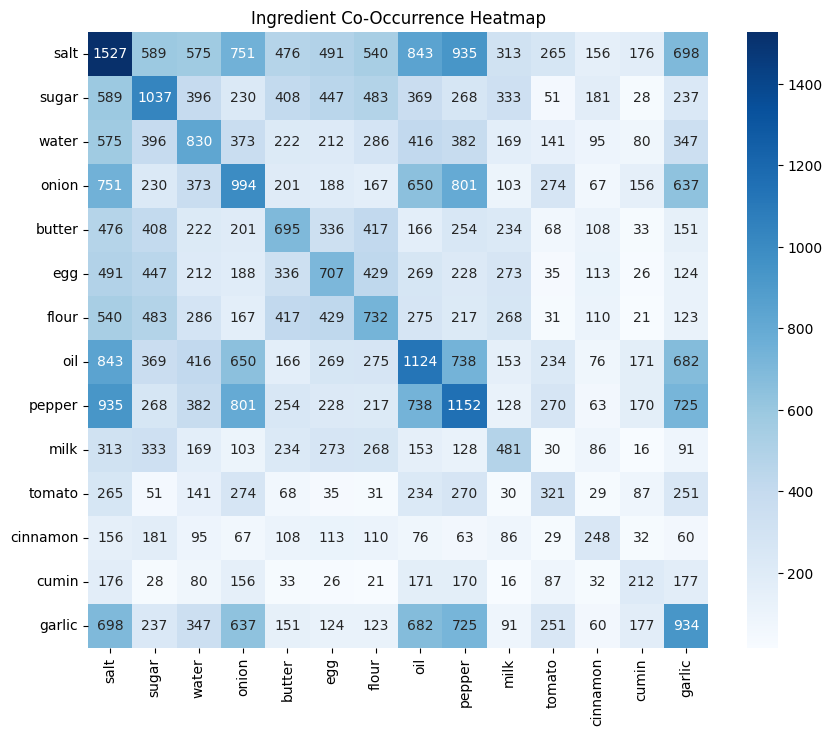

In [119]:
# Ensure only valid ingredients are used
valid_ingredients = [i for i in top_ingredient_names if i in co_matrix_df.index]

# Extract sub-matrix
sub_matrix = co_matrix_df.loc[valid_ingredients, valid_ingredients]

# Plot the heatmap
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.heatmap(sub_matrix, cmap="Blues", annot=True, fmt=".0f")
plt.title("Ingredient Co-Occurrence Heatmap")
plt.show()


In [120]:
output_file = 'clean_recipes_with_ingredients.json'
df.to_json(output_file, orient='records', lines=True)

print(f"DataFrame successfully saved to {output_file}")

DataFrame successfully saved to clean_recipes_with_ingredients.json


In [121]:
import json
from collections import defaultdict
import pandas as pd

# Load your JSON data (example structure shown below)
# [{"title": "Dutch Boterkoek", "ingredients": [...], "cuisine": "Dutch"}, ...]
with open('clean_recipes_with_ingredients.json') as f:
    recipes = [json.loads(line) for line in f]

# Step 1: Count ingredient co-occurrences per cuisine
co_occurrence = defaultdict(lambda: defaultdict(int))
ingredient_counts = defaultdict(int)

for recipe in recipes:
    cuisine = recipe['cuisine']
    ingredients = recipe['ingredients']

    # Update ingredient frequencies
    for ing in ingredients:
        ingredient_counts[(cuisine, ing)] += 1

    # Update co-occurrences
    for i in range(len(ingredients)):
        for j in range(i + 1, len(ingredients)):
            pair = tuple(sorted([ingredients[i], ingredients[j]]))
            co_occurrence[cuisine][pair] += 1

# Step 2: Build the hierarchy (D3.js-compatible JSON)
def build_hierarchy(co_occurrence, ingredient_counts):
    hierarchy = {"name": "cuisines", "children": []}

    for cuisine in set(r['cuisine'] for r in recipes):
        cuisine_node = {
            "name": cuisine,
            "children": [],
            "value": sum(v for (c, _), v in ingredient_counts.items() if c == cuisine)
        }

        # Add ingredients (leaf nodes)
        ingredients_in_cuisine = [
            ing for (c, ing), cnt in ingredient_counts.items()
            if c == cuisine
        ]

        for ing in ingredients_in_cuisine:
            cuisine_node["children"].append({
                "name": ing,
                "value": ingredient_counts[(cuisine, ing)],
                "cuisine": cuisine
            })

        hierarchy["children"].append(cuisine_node)

    return hierarchy

# Step 3: Add links between ingredients (for edge bundling)
def add_links(hierarchy, co_occurrence):
    links = []

    for cuisine in co_occurrence:
        for (ing1, ing2), weight in co_occurrence[cuisine].items():
            links.append({
                "source": ing1,
                "target": ing2,
                "value": weight,
                "cuisine": cuisine
            })

    return {
        "hierarchy": hierarchy,
        "links": links
    }

# Generate the final JSON
hierarchy = build_hierarchy(co_occurrence, ingredient_counts)
heb_data = add_links(hierarchy, co_occurrence)

# Save for D3.js
with open('data/heb_data.json', 'w') as f:
    json.dump(heb_data, f, indent=2)

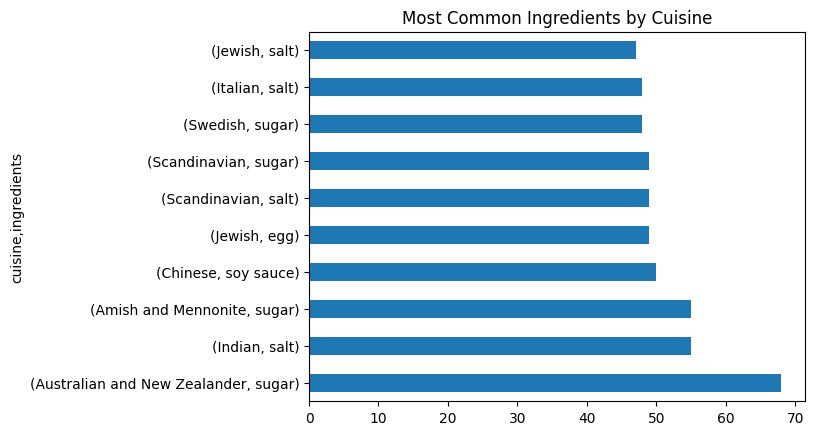

In [122]:
import pandas as pd
import matplotlib.pyplot as plt

# Load your data
df = pd.read_json('clean_recipes_with_ingredients.json', lines=True)

# Top 10 ingredients per cuisine
top_ingredients = (
    df.explode('ingredients')
    .groupby(['cuisine', 'ingredients']).size()
    .sort_values(ascending=False)
    .head(10)
)

top_ingredients.plot(kind='barh')
plt.title('Most Common Ingredients by Cuisine')
plt.show()